In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import time
torch.backends.cudnn.benchmark = True
import os
import polars as pl
from torch.utils.data import Dataset
import platform
import seaborn as sbn
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader

# Dataset

In [2]:
class CalorichPointNetDataset(Dataset):
    def __init__(self, point_net_dataset_path):
        """Constructor"""
        self.point_net_dataset = (
            pl.read_parquet(point_net_dataset_path)
            .filter(pl.col('ring_radius_cal').is_not_nan())
        )

    def __len__(self):
        """Size of the dataset"""
        return self.point_net_dataset.shape[0]

    def __getitem__(self, idx):
        """Get a particular item of the dataset"""
        
        start = time.time()

        noise = np.random.normal(0, 0.05, 50)
        noise = np.expand_dims(noise, 1)
        noise = torch.Tensor(noise)
        
        values = {
            "hits": (
                torch.cat((torch.tensor(self.point_net_dataset.select("hits_xy_adjusted").row(idx)).squeeze(), noise), -1).to(device)
            ),
            "ring_radius_cal":(
                torch.tensor(self.point_net_dataset.select("ring_radius_cal").row(idx)).squeeze().to(device)
            ),
            "composite_id":(
                torch.tensor(self.point_net_dataset.select("composite_event_id").row(idx)).squeeze().to(device)
            )
        }

        end = time.time()


        return values

# PointNet

In [3]:
class PointNetRegression(nn.Module):
    def __init__(self, num_features, num_output):
        """Initialize PointNet

        Parameters
        ----------

        num_features : int
            Number of dimensions of the input data 
        """
        
        super(PointNetRegression, self).__init__()
        
        # Input transformation network
        self.input_transform = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, kernel_size=1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        # Feature transformation network
        self.feature_transform = nn.Sequential(
            nn.Conv1d(1024, 512, kernel_size=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 256, kernel_size=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        
        # Fully connected layers for regression
        self.fc_regression = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_output)
        )

    def forward(self, x):
        """ Forward pass of the PointNet network

        Parameters
        ----------

        x : tensor
            Tensor containing the weight values from the previous pass
        
        """

        batch_size = x.size(0)
        
        # Input transformation network
        x = self.input_transform(x)
        
        # Global feature extraction
        x = torch.max(x, 2, keepdim=True)[0]
        
        # Feature transformation network
        x = self.feature_transform(x)
        
        # Global feature vector
        x = torch.max(x, 2, keepdim=False)[0]

        # Fully connected layers for regression
        x = self.fc_regression(x)
        
        return x

# Load Model Weights

In [6]:
model = PointNetRegression(50, 1)
model.load_state_dict(torch.load('/Users/merigo/Documents/MDS_2022/Capstone/Repos/project/saved_models/model_weights/old_pointnet_train_muon_state_dict.pt', map_location = device))
model.eval()

PointNetRegression(
  (input_transform): Sequential(
    (0): Conv1d(50, 64, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (feature_transform): Sequential(
    (0): Conv1d(1024, 512, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
    (7): BatchNorm1d(128, eps=1e-05, 

# Get the test data

In [7]:
test_dataset = CalorichPointNetDataset('/Users/merigo/Documents/MDS_2022/Capstone/Repos/project/data/point_net_[test_muons,cut_off_time=0.5,sample_size=50].parquet')

In [8]:
test_loader = DataLoader(test_dataset, batch_size=4000, num_workers = 0, pin_memory = False)

# Get Predictions

In [9]:
results = []
calc_ring_radius = []
composite_id = []

with torch.no_grad():
            for i, d in enumerate(test_loader):
                X = d['hits'].float()
                y = d['ring_radius_cal'].float().to(device)
                y = y.unsqueeze(1)
                comp_id = d['composite_id'].to(device)

                preds = model(X)
                preds_arr = preds.detach().cpu().numpy()

                results.append(preds_arr)
                y_arr = y.detach().cpu().numpy()
                calc_ring_radius.append(y_arr)

                id_arr = comp_id.detach().cpu().numpy()
                composite_id.append(id_arr)

In [10]:
composite_events_id = []
for i in np.arange(0, len(composite_id)):
    for j in composite_id[i]:
        composite_events_id.append(j)

In [11]:
entire_results = np.vstack(results)
entire_calc_ring = np.vstack(calc_ring_radius)

In [12]:
residuals = np.subtract(entire_calc_ring, entire_results)

In [13]:
residuals_df = pd.DataFrame(list(zip(entire_results.ravel().tolist(), entire_calc_ring.ravel().tolist(), residuals.ravel().tolist(), composite_events_id)),
columns = ['Predicted', 'Theoretical', 'Residuals', 'composite_events_id'])

In [14]:
residuals_df = pl.from_pandas(residuals_df)

In [15]:
residuals_df.head()

Predicted,Theoretical,Residuals,composite_events_id
f64,f64,f64,i64
182.59967,184.629135,2.029465,6102523641129904
185.788055,188.784668,2.996613,6102657571224176
184.496384,183.089539,-1.406845,6102491148214624
179.759323,182.075027,2.315704,6102594748716032
181.45546,174.276138,-7.179321,6102553157980704


In [16]:
residuals_df['Residuals'].min()

-170.21823120117188

In [17]:
residuals_df = residuals_df.rename({'composite_events_id' : 'composite_event_id'})

In [18]:
residuals_df.head()

Predicted,Theoretical,Residuals,composite_event_id
f64,f64,f64,i64
182.59967,184.629135,2.029465,6102523641129904
185.788055,188.784668,2.996613,6102657571224176
184.496384,183.089539,-1.406845,6102491148214624
179.759323,182.075027,2.315704,6102594748716032
181.45546,174.276138,-7.179321,6102553157980704


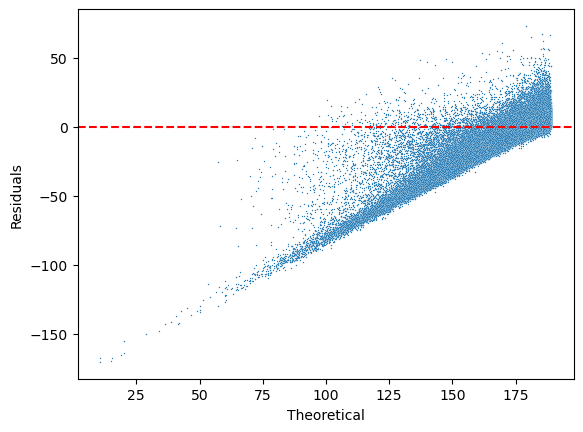

In [19]:
sbn.scatterplot(residuals_df, x = 'Theoretical', y = 'Residuals', s = 1)
plt.axhline(y=0, color='red', linestyle='--')

Here we can see a distribution of the residuals that shows a trend in the residuals that is not following the zero line (red dotted line), meaning that the model is not learning the behaviour of the labels in the training data. This unfortunately means that the PointNet model is not working at the moment and point to the probability of a vanishing gradient.

## Merge hits and events data to obtain the momentum per event

In [20]:
events_df = pl.read_parquet('/Users/merigo/Documents/MDS_2022/Capstone/Repos/project/data/events.parquet')

In [21]:
type(events_df)

polars.dataframe.frame.DataFrame

In [22]:
events_df = events_df.with_columns(pl.col('composite_event_id').cast(pl.Int64))

In [23]:
events_df.head()

run_id,burst_id,event_id,track_id,track_momentum,chod_time,track_pos_x,track_pos_y,ring_radius,ring_centre_pos_x,ring_centre_pos_y,ring_likelihood_pion,ring_likelihood_muon,ring_likelihood_positron,ring_likelihood_kaon,ring_likelihood_background,label,total_hits,class,mass,composite_event_id,ring_radius_cal
u32,u16,u64,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u8,u16,str,f32,i64,f32
11100,1468,11235,0,22.761024,7.789327,-195.126602,-153.930786,172.41095,-190.112167,-154.579514,2.0840e-12,1.0,1.9142e-24,1.2161e-37,1.2161e-37,0,20,"""muon""",105.660004,6102683597585968,173.410156
11100,1468,11812,0,23.600529,0.000198,-316.197571,-57.275291,175.251694,-309.305939,-54.84441,7.7320e-10,1.0,8.2757e-19,1.2161e-37,1.2161e-37,0,19,"""muon""",105.660004,6102683597595200,174.660522
11100,1468,14104,0,16.275131,11.789481,-88.681786,58.657421,155.040802,-88.66584,59.053833,1.2161e-37,1.0,1.2161e-37,1.2161e-37,1.2161e-37,0,26,"""muon""",105.660004,6102683597631872,155.299332
11100,1468,14634,1,36.436443,7.426493,-39.124882,81.853058,185.832642,-35.864372,80.70858,0.008006,1.0,0.036262,1.2161e-37,1.2161e-37,0,52,"""muon""",105.660004,6102683597640353,184.0354
11100,1468,18030,0,16.525362,8.923427,-66.697784,-15.932317,158.641846,-65.450981,-20.469883,1.2161e-37,1.0,1.2161e-37,1.2161e-37,1.2161e-37,0,24,"""muon""",105.660004,6102683597694688,156.473602


In [24]:
joined_df = residuals_df.join(events_df, on= 'composite_event_id', how = 'left')

In [25]:
joined_df.head()

Predicted,Theoretical,Residuals,composite_event_id,run_id,burst_id,event_id,track_id,track_momentum,chod_time,track_pos_x,track_pos_y,ring_radius,ring_centre_pos_x,ring_centre_pos_y,ring_likelihood_pion,ring_likelihood_muon,ring_likelihood_positron,ring_likelihood_kaon,ring_likelihood_background,label,total_hits,class,mass,ring_radius_cal
f64,f64,f64,i64,u32,u16,u64,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u8,u16,str,f32,f32
182.59967,184.629135,2.029465,6102523641129904,11100,872,1953467,0,38.197041,9.599691,-98.346466,100.966988,184.834183,-97.295349,98.706764,0.000525,1.0,0.100119,1.2161e-37,1.2161e-37,0,31,"""muon""",105.660004,184.629135
185.788055,188.784668,2.996613,6102657571224176,11100,1371,753575,0,69.928093,16.117001,-17.22547,10.165514,190.639648,-11.099981,8.986593,0.188849,0.398394,1.0,1.2161e-37,1.2161e-37,0,23,"""muon""",105.660004,188.784668
184.496384,183.089539,-1.406845,6102491148214624,11100,751,1189398,0,34.082951,6.896775,-84.576096,111.080841,182.794205,-85.978271,111.835403,0.0673,1.0,0.001662,1.2161e-37,1.2161e-37,0,53,"""muon""",105.660004,183.089539
179.759323,182.075027,2.315704,6102594748716032,11100,1137,215360,0,32.014858,7.513248,-42.214909,86.230034,187.975677,-37.832165,91.121933,0.000112,1.0,0.004204,1.2161e-37,1.2161e-37,0,17,"""muon""",105.660004,182.075027
181.45546,174.276138,-7.179321,6102553157980704,11100,982,1262882,0,23.331972,10.623532,-10.833614,-18.336449,173.069,-15.793177,-16.863462,5.8529e-12,1.0,8.3349e-17,1.2161e-37,1.2161e-37,0,32,"""muon""",105.660004,174.276138


In [26]:
test = joined_df.select('track_momentum')

In [27]:
test = test.to_series()

In [28]:
test

track_momentum
f32
38.197041
69.928093
34.082951
32.014858
23.331972
14.303932
51.327255
25.855909
46.751801


In [29]:
test.max()

74.0513916015625

In [30]:
test = test.cut(np.arange(0, 75, 1))

In [31]:
test = test.with_columns(pl.col('track_momentum').cast(pl.Float32))

In [32]:
test

track_momentum,break_point,category
f32,f64,cat
9.442538,10.0,"""(9.0, 10.0]"""
9.442658,10.0,"""(9.0, 10.0]"""
9.457255,10.0,"""(9.0, 10.0]"""
9.457991,10.0,"""(9.0, 10.0]"""
9.474362,10.0,"""(9.0, 10.0]"""
9.480124,10.0,"""(9.0, 10.0]"""
9.480509,10.0,"""(9.0, 10.0]"""
9.536498,10.0,"""(9.0, 10.0]"""
9.581163,10.0,"""(9.0, 10.0]"""


In [33]:
joined_df = joined_df.join(test, on = 'track_momentum')

Text(0.5, 0, 'Momentum Bin')

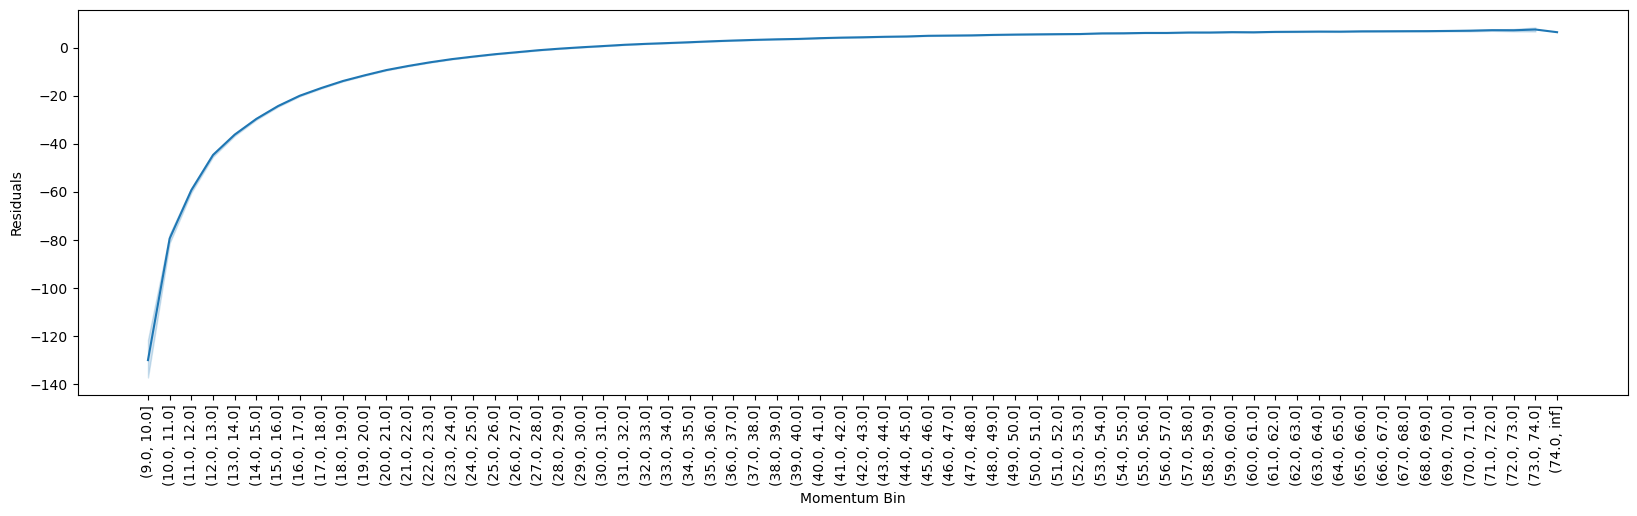

In [34]:
sbn.lineplot(data = joined_df, x = 'category', y = 'Residuals')
fig = plt.gcf()
plt.xticks(rotation=90)
fig.set_size_inches(20, 5)
plt.xlabel('Momentum Bin')

In this plot, which represents the relationship between the mean residuals and the momentum bins (1 GeV per bin). The plot also contains the 95% confidence interval (the blue shadow) showing that from the momentum 25 the residuals start to stabilize around 0, this suggests that the model is deficient in lower momentum ranges which tend to have more variable ring radii; again suggesting that the model is not learning a pattern in the entire data range but settling for the most common values which are stable in later momentum ranges.

Text(0.5, 0, 'Momentum Bin')

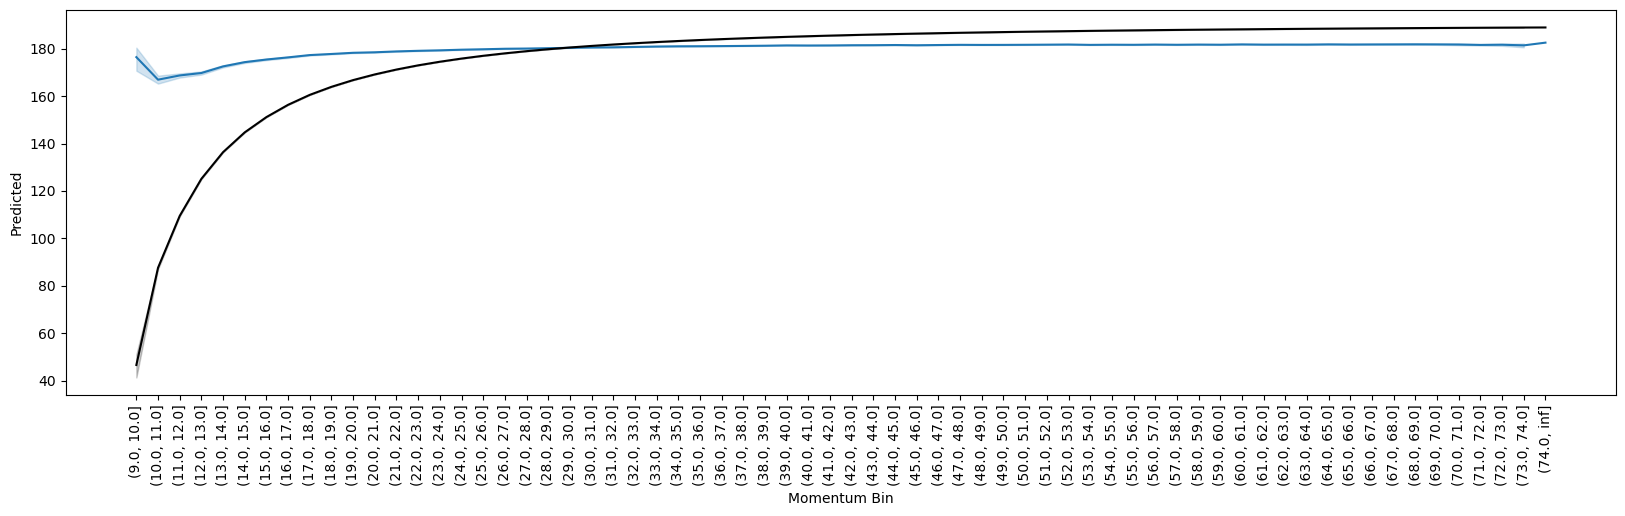

In [35]:
sbn.lineplot(data = joined_df, x = 'category', y = 'Predicted')
sbn.lineplot(data = joined_df, x = 'category', y = 'Theoretical', color = 'black')
fig = plt.gcf()
plt.xticks(rotation=90)
fig.set_size_inches(20, 5)
plt.xlabel('Momentum Bin')

Finally here we can see that, when compared to the calculated ring radius (black line) the model predictions seem to plateau soon and maintain a stable value, proving the assumption that no pattern was being captured by the PointNet model.

Text(0.5, 0, 'Momentum Bin')

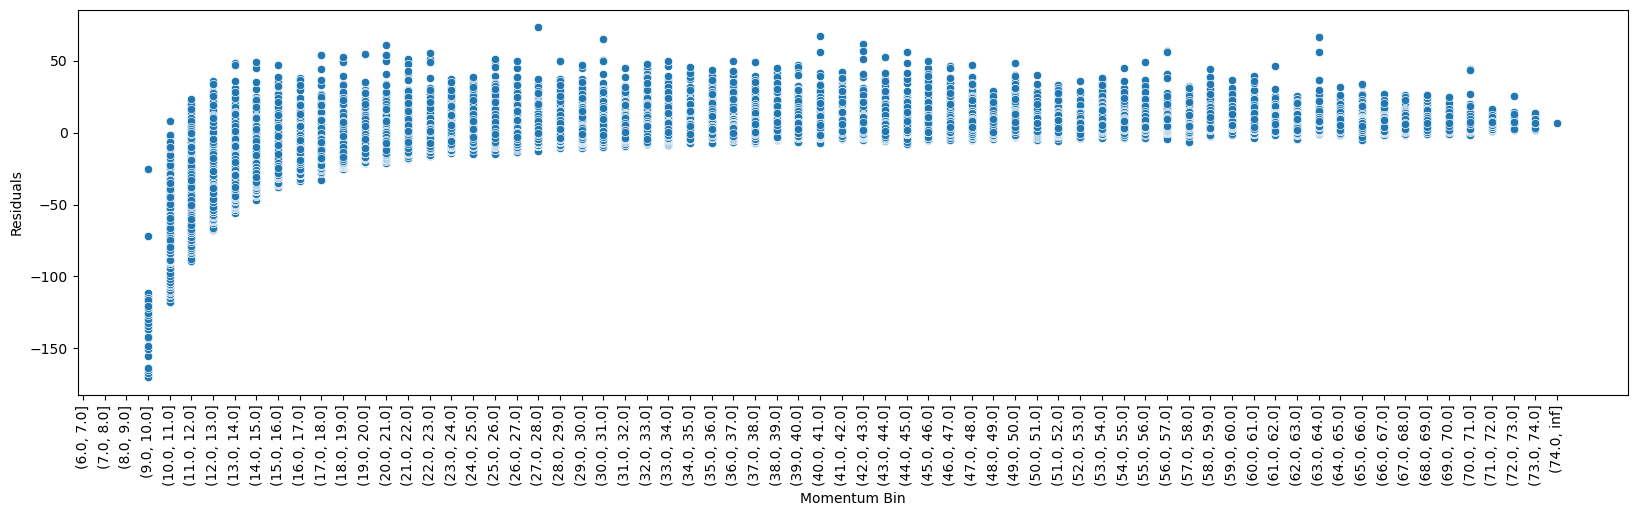

In [36]:
sbn.scatterplot(data = joined_df.to_pandas(), x = 'category', y = 'Residuals')
fig = plt.gcf()
plt.xticks(rotation=90)
fig.set_size_inches(20, 5)
plt.xlabel('Momentum Bin')

Text(0.5, 0, 'Momentum Bin')

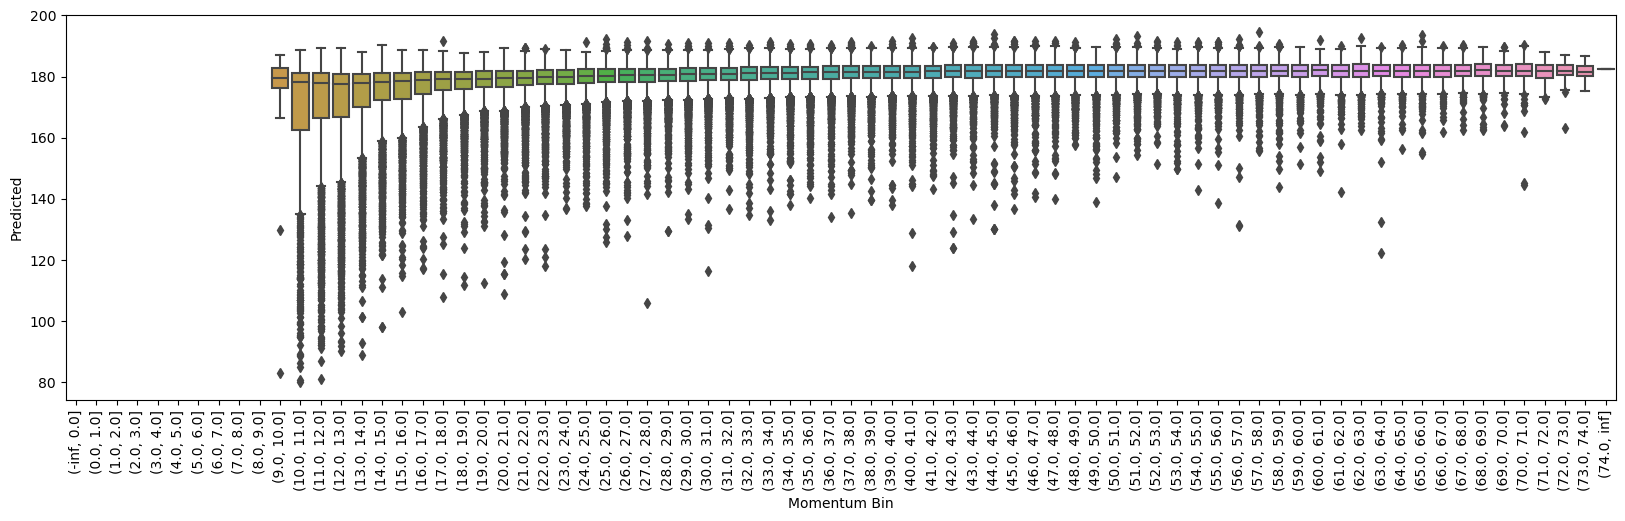

In [37]:
sbn.boxplot(data = joined_df.to_pandas(), x = 'category', y = 'Predicted')
fig = plt.gcf()
plt.xticks(rotation=90)
fig.set_size_inches(20, 5)
plt.xlabel('Momentum Bin')

In [38]:
joined_df.select('category').unique().sort(by = 'category').tail(20)

category
cat
"""(55.0, 56.0]"""
"""(56.0, 57.0]"""
"""(57.0, 58.0]"""
"""(58.0, 59.0]"""
"""(59.0, 60.0]"""
"""(60.0, 61.0]"""
"""(61.0, 62.0]"""
"""(62.0, 63.0]"""
"""(63.0, 64.0]"""


In [39]:
later_subset_joined_df = joined_df.filter(pl.col('category').is_in(joined_df.select('category').unique().sort(by = 'category').tail(50).to_series()))

Text(0.5, 0, 'Momentum Bin')

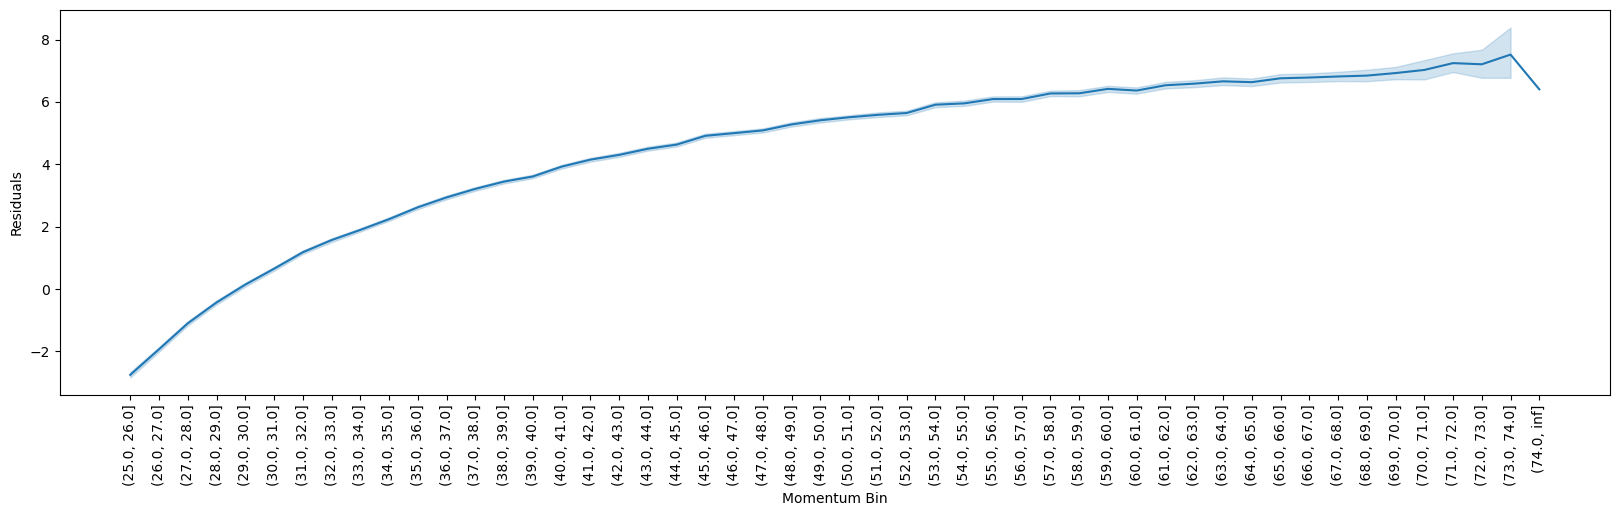

In [40]:
sbn.lineplot(data = later_subset_joined_df, x = 'category', y = 'Residuals')
fig = plt.gcf()
plt.xticks(rotation=90)
fig.set_size_inches(20, 5)
plt.xlabel('Momentum Bin')

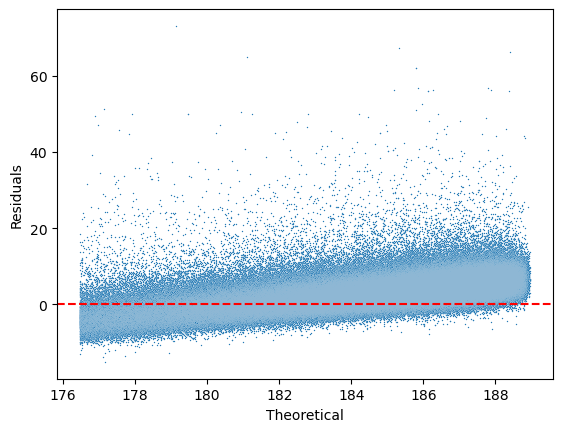

In [41]:
sbn.scatterplot(later_subset_joined_df, x = 'Theoretical', y = 'Residuals', s = 1)
plt.axhline(y=0, color='red', linestyle='--')

Text(0.5, 1.0, 'Predicted Vs Theoretical Ring Radius')

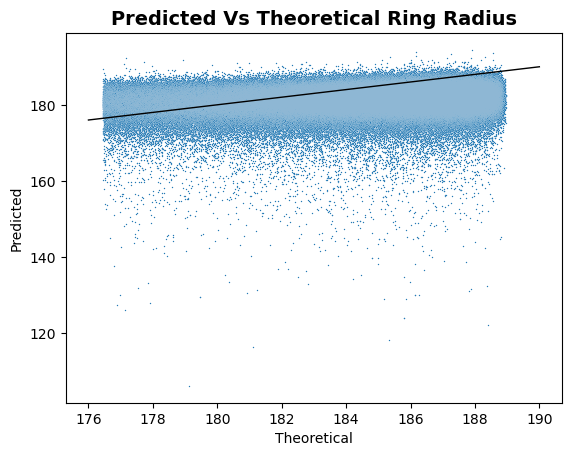

In [42]:
sbn.scatterplot(later_subset_joined_df, x = 'Theoretical', y = 'Predicted', s = 1)
plt.plot([176, 190], [176, 190], color='black', linestyle='-', linewidth=1)
plt.title('Predicted Vs Theoretical Ring Radius', fontsize= 14, weight = 'bold')

This plot as well as the immediate previous one confirm our suspicions, the PointNet model is not following the ground truth (shown as a black line in the Predicted Vs Theoretical Plot), istead it is following a constant pattern. This again confirms the fact that the model is setlling for a common value and not a trend.

Text(0.5, 0, 'Theoretical')

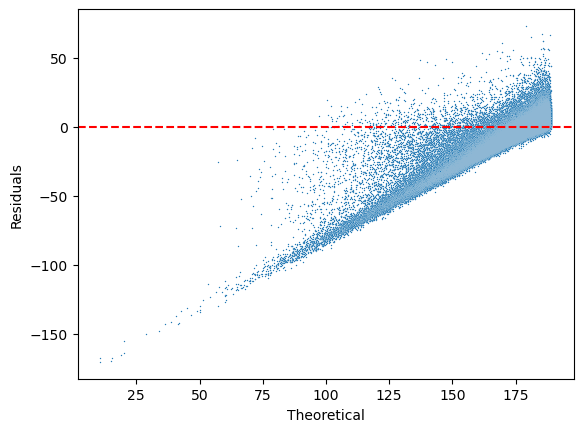

In [43]:
sbn.scatterplot(data = joined_df, x = 'ring_radius_cal', y = 'Residuals', s = 1)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Theoretical')

# Metrics for the entire test dataset

## R2

In [44]:
from sklearn.metrics import r2_score

r2 = r2_score(residuals_df['Theoretical'], residuals_df['Predicted'])

In [45]:
r2

0.14481948109184062

## MAE

In [46]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(residuals_df['Theoretical'], residuals_df['Predicted'])

In [47]:
mae

6.270154521659631

Compared to XGBoost these metrics are inferior, thus we are concluding that XGBoost is better suited at the moment.

# Future Suggestions

Based on the fact that this model is not learning from the training data supplied to it I suggest the following:

1. Create a new dataset and make sure to capture trhe entire data range
2. Test the convolutional network with an input feature number of 2 and avoid performing the gaussian noise procedure to generate a 3rd
3. Substitute the 3rd dimension witht he median hit distance (the most important engineered feature from the XGBoost experiment)
4. Try the model on lower momentum bins only, to make sure the model is actually learning